# Import neccessary Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Load Data set

In [2]:
netflix_data = pd.read_csv('./NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv')
netflix_data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [3]:
netflix_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


In [4]:
print(f"There are {netflix_data.shape[0]} rows and {netflix_data.shape[1]} columns in the netflix dataset.")

There are 7787 rows and 12 columns in the netflix dataset.


In [5]:
print(f"Columns in the netflix dataset: {netflix_data.columns}")

Columns in the netflix dataset: Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [6]:
print("checking null values in the netflix dataset:")
netflix_data.isnull().sum()

checking null values in the netflix dataset:


show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
dtype: int64

In [7]:
country_data = netflix_data.country.dropna().str.split(', ').explode().value_counts()
country_data = country_data.head(10)
print("Finding Top 10 country has highest number of moveies and tv shows:")
country_data

Finding Top 10 country has highest number of moveies and tv shows:


country
United States     3296
India              990
United Kingdom     722
Canada             412
France             349
Japan              287
Spain              215
South Korea        212
Germany            199
Mexico             154
Name: count, dtype: int64

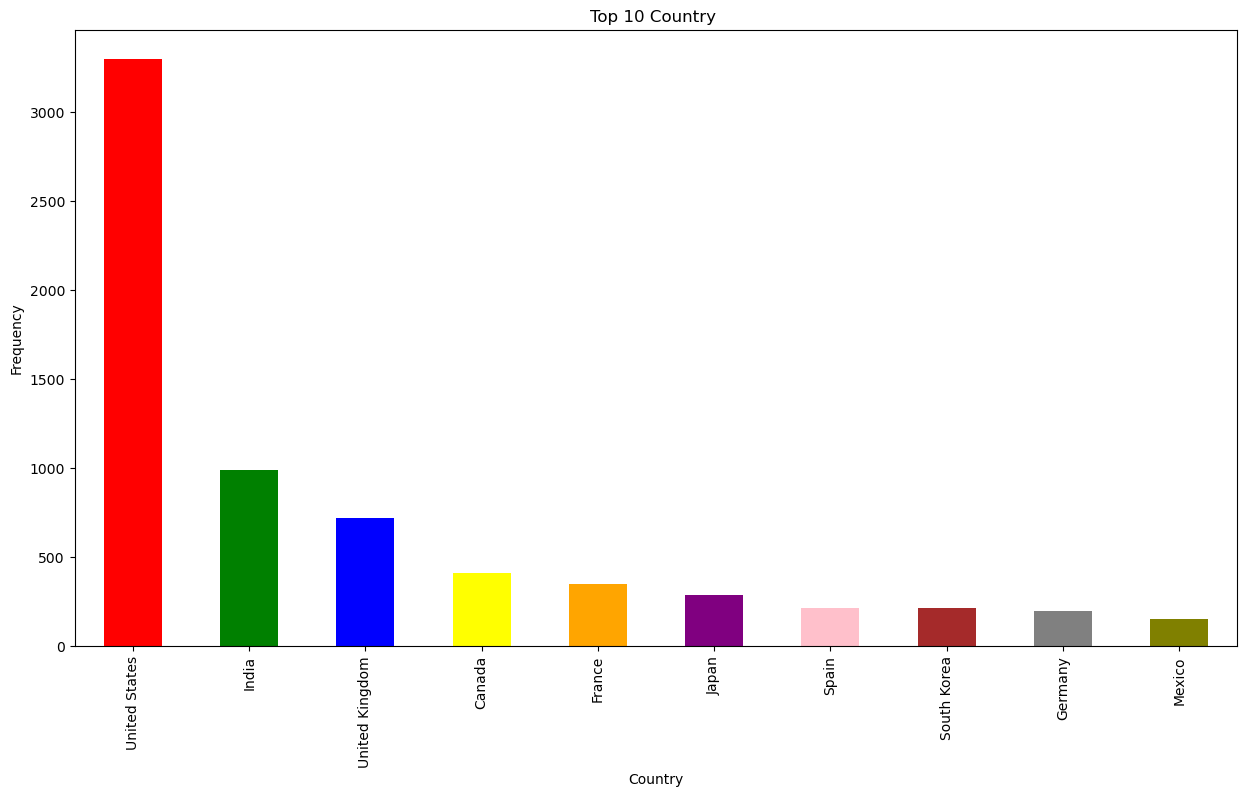

In [8]:

colors = [
    'red', 'green', 'blue', 'yellow', 'orange',
    'purple', 'pink', 'brown', 'gray', 'olive',
    'cyan', 'teal', 'lime', 'coral', 'salmon',
    'navy', 'maroon', 'turquoise', 'silver', 'gold'
]

country_data.plot(kind='bar', figsize=(15, 8), color=colors[:len(country_data)])
plt.title('Top 10 Country ')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.show()



In [9]:
type_trends = netflix_data.groupby(['release_year', 'type']).size().unstack().fillna(0)
type_trends.tail(10)

type,Movie,TV Show
release_year,,
2012,158.0,61.0
2013,202.0,65.0
2014,244.0,90.0
2015,382.0,159.0
2016,642.0,240.0
2017,744.0,268.0
2018,734.0,387.0
2019,582.0,414.0
2020,411.0,457.0


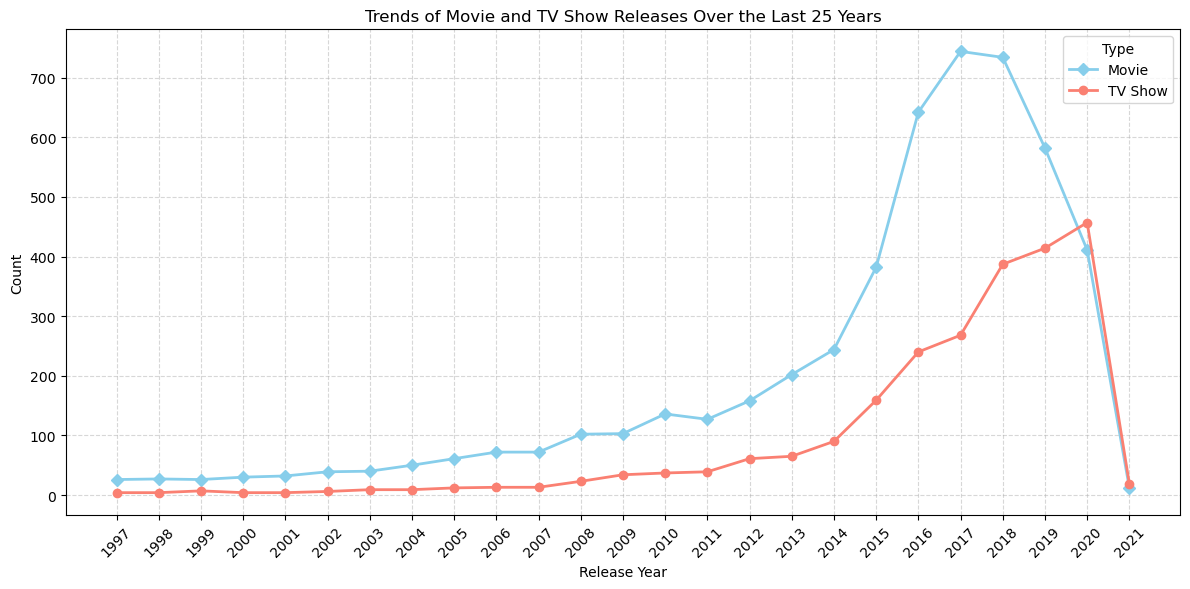

In [10]:
# Filter for the last 25 years
last_25_years = type_trends.tail(25)
# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(last_25_years.index, last_25_years['Movie'], marker='D', label='Movie', color='skyblue', linewidth=2)
plt.plot(last_25_years.index, last_25_years['TV Show'], marker='o', label='TV Show', color='salmon', linewidth=2)
# Titles and labels
plt.title('Trends of Movie and TV Show Releases Over the Last 25 Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.legend(title='Type')
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust x-ticks for readability
plt.xticks(last_25_years.index, rotation=45)

plt.tight_layout()
plt.show()

Analyzing the data from the last 25 years reveals a notable trend in the release patterns of movies and TV shows. Historically, movies have consistently trended higher than TV shows, indicating a stronger demand and production volume for cinematic content. However, a significant shift occurs in 2018, marking a turning point in this trend. Since then, movie releases have been declining, while TV show releases have continued to rise. This reversal suggests a changing landscape in consumer preferences, potentially driven by the growing popularity of streaming services and the increasing quality of television content

In [44]:
# Combinng 'description' and 'listed_in' columns to create a text corpus for clustering
netflix_data['combined_text'] = netflix_data['description'] + ' ' + netflix_data['listed_in']
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(netflix_data['combined_text'].fillna(''))

Number of Clusters: 2
Inertia: 7518.066046037642
Silhouette Score: 0.011035833595202644

Number of Clusters: 3
Inertia: 7474.707806253427
Silhouette Score: 0.013406374908075443

Number of Clusters: 4
Inertia: 7442.623892191941
Silhouette Score: 0.014075067501074226

Number of Clusters: 5
Inertia: 7413.665392818941
Silhouette Score: 0.014727309069742496

Number of Clusters: 6
Inertia: 7385.510763272243
Silhouette Score: 0.012625554214862987

Number of Clusters: 7
Inertia: 7360.62824801129
Silhouette Score: 0.013277695386771237

Number of Clusters: 8
Inertia: 7340.916716128818
Silhouette Score: 0.013954797328689374

Number of Clusters: 9
Inertia: 7327.544069580962
Silhouette Score: 0.007934758221876415

Number of Clusters: 10
Inertia: 7303.5306174141815
Silhouette Score: 0.014215595205680403

Number of Clusters: 11
Inertia: 7298.155403240423
Silhouette Score: 0.014145078017138367

Number of Clusters: 12
Inertia: 7275.124163842823
Silhouette Score: 0.015024330576039163

Number of Clusters

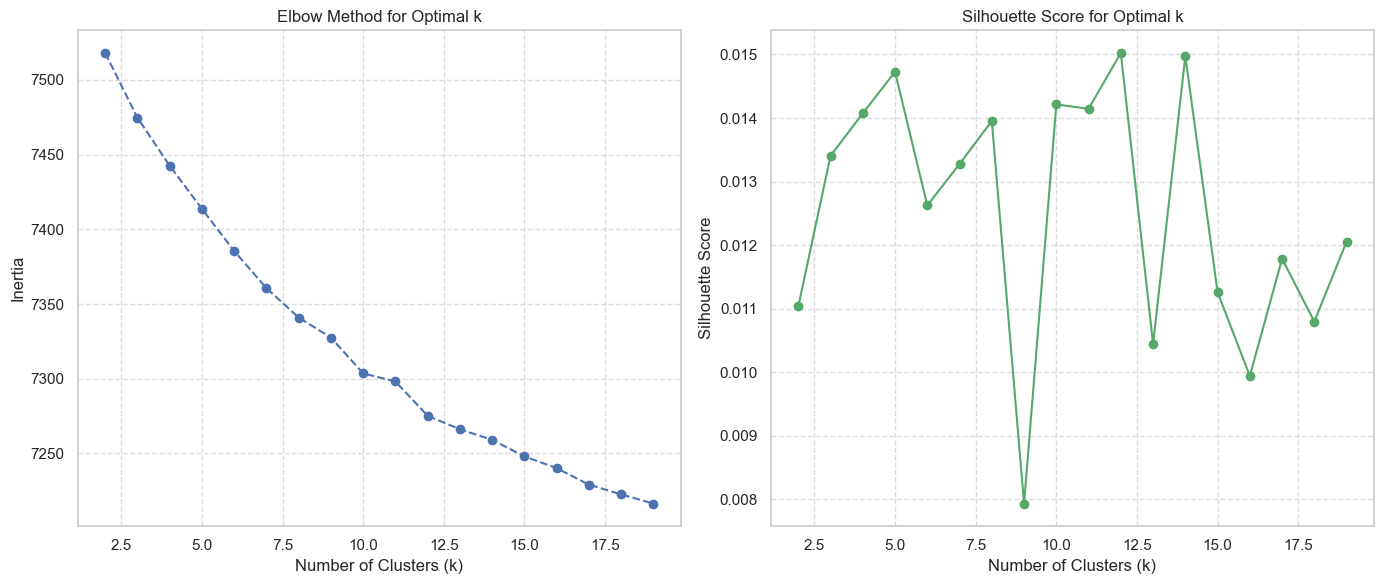

In [47]:

# Combine 'description' and 'listed_in' columns to create a text corpus for clustering
netflix_data['combined_text'] = netflix_data['description'] + ' ' + netflix_data['listed_in']

# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(netflix_data['combined_text'].fillna(''))

# Apply the elbow method and silhouette score calculation
inertia = []
silhouette_scores = []
k_values = range(2, 20)  # Test cluster numbers from 2 to 15, since silhouette score needs at least 2 clusters

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    
    # Calculate inertia
    inertia.append(kmeans.inertia_)
    
    # Calculate silhouette score
    score = silhouette_score(tfidf_matrix, kmeans.labels_)
    silhouette_scores.append(score)
    
    # Printing values
    print(f"Number of Clusters: {k}")
    print(f"Inertia: {kmeans.inertia_}")
    print(f"Silhouette Score: {score}\n")

# Plot inertia vs. number of clusters
plt.figure(figsize=(14, 6))

# Subplot for inertia plot
plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot for silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='g')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


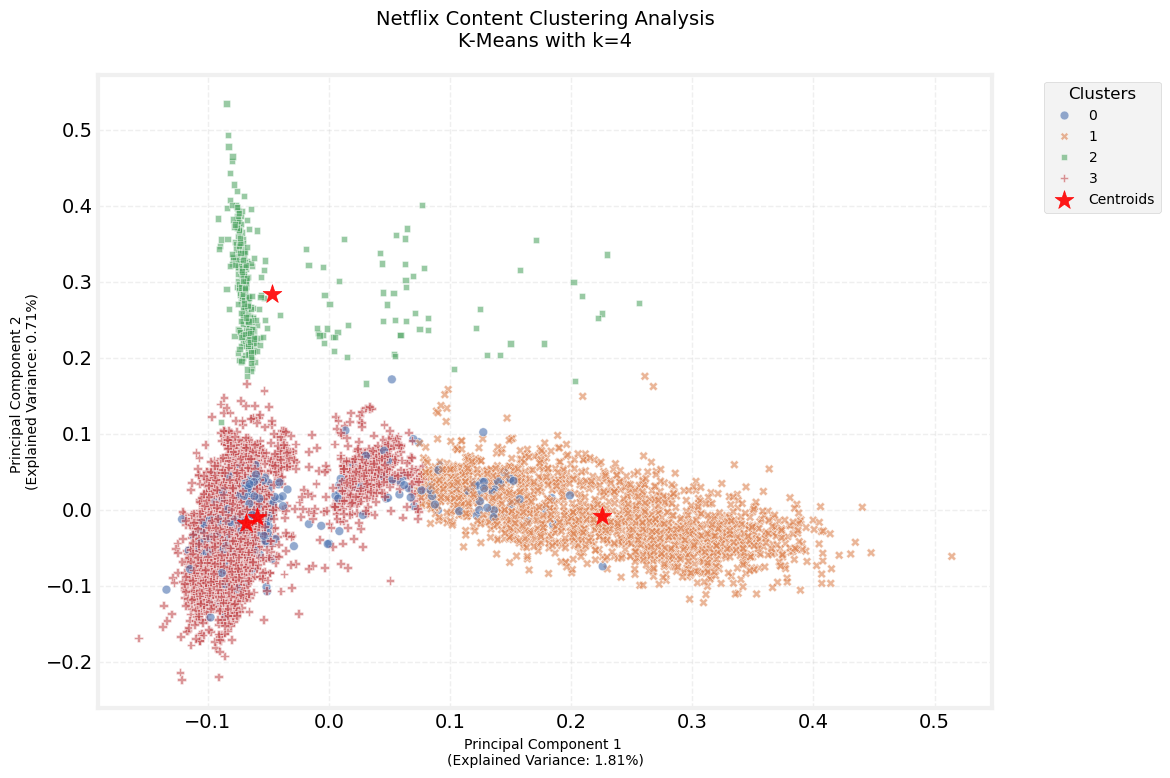


Cluster Sizes:
cluster
0     909
1    1750
2     383
3    4745
Name: count, dtype: int64


In [12]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
netflix_data['cluster']= kmeans.fit_predict(tfidf_matrix)
# Dimensionality reduction for visualization
pca = PCA(n_components=2, random_state=42)
tfidf_reduced = pca.fit_transform(tfidf_matrix.toarray())
# Create a DataFrame with the reduced data and clusters
df_plot = pd.DataFrame(tfidf_reduced, columns=['PC1', 'PC2'])
df_plot['cluster'] = netflix_data['cluster']

# Set the style for better visualization
plt.style.use('fivethirtyeight')  # Using a built-in style

# Create the plot with enhanced parameters
plt.figure(figsize=(12, 8))

# Create scatter plot with improved parameters
sns.scatterplot(data=df_plot, 
                x='PC1', 
                y='PC2', 
                hue='cluster',
                palette='deep',  # Using a more distinctive color palette
                s=40,           # Slightly smaller point size
                alpha=0.6,      # More transparency to show density
                style='cluster')  # Different markers for each cluster

# Plot cluster centers
centers = kmeans.cluster_centers_
centers_2d = pca.transform(centers)
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
           c='red',
           marker='*',
           s=200,
           alpha=0.9,
           label='Centroids')

# Enhance the plot aesthetics
plt.title('Netflix Content Clustering Analysis\nK-Means with k=4', 
          fontsize=14, 
          pad=20)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)

# Add a more detailed legend
plt.legend(title='Clusters', title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid with custom style
plt.grid(True, linestyle='--', alpha=0.3)

# Add percentage of variance explained by each principal component
variance_ratio = pca.explained_variance_ratio_
plt.xlabel(f'Principal Component 1 \n(Explained Variance: {variance_ratio[0]:.2%})', fontsize=10)
plt.ylabel(f'Principal Component 2 \n(Explained Variance: {variance_ratio[1]:.2%})', fontsize=10)

# Set white background
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary statistics
print("\nCluster Sizes:")
print(df_plot['cluster'].value_counts().sort_index())


In [13]:
# Prepare the analysis data
cluster_analysis = []

for i in range(num_clusters):
    cluster_data = netflix_data[netflix_data['cluster'] == i]
    top_genres = cluster_data['listed_in'].value_counts().head(5).to_dict()
    type_distribution = cluster_data['type'].value_counts().to_dict()
    
    cluster_analysis.append({
        'Cluster': i,
        'Top Genres': top_genres,
        'Type Distribution': type_distribution
    })

# Convert the analysis into a DataFrame for a tabular view
cluster_analysis_df = pd.DataFrame(cluster_analysis)

# Set display options to prevent truncation
pd.set_option('display.max_colwidth', None)  # Disable column width limit for display
pd.set_option('display.max_rows', None)      # Show all rows if needed

# Display the DataFrame
cluster_analysis_df



,Cluster,Top Genres,Type Distribution
0,0,"{'Action & Adventure, Dramas, International Movies': 117, 'Action & Adventure': 99, 'Action & Adventure, International Movies': 88, 'Action & Adventure, Comedies, International Movies': 67, 'Action & Adventure, Sci-Fi & Fantasy': 52}","{'Movie': 836, 'TV Show': 73}"
1,1,"{'International TV Shows, TV Dramas': 111, 'Crime TV Shows, International TV Shows, TV Dramas': 106, 'International TV Shows, Romantic TV Shows, TV Dramas': 86, 'Kids' TV, TV Comedies': 85, 'International TV Shows, Romantic TV Shows, TV Comedies': 79}",{'TV Show': 1750}
2,2,"{'Stand-Up Comedy': 321, 'Stand-Up Comedy & Talk Shows, TV Comedies': 26, 'International TV Shows, Stand-Up Comedy & Talk Shows, TV Comedies': 7, 'Stand-Up Comedy & Talk Shows': 6, 'Music & Musicals, Stand-Up Comedy': 6}","{'Movie': 332, 'TV Show': 51}"
3,3,"{'Documentaries': 332, 'Dramas, International Movies': 320, 'Comedies, Dramas, International Movies': 241, 'Dramas, Independent Movies, International Movies': 215, 'Kids' TV': 188}","{'Movie': 4209, 'TV Show': 536}"


In [14]:
# Get feature names from the TF-IDF vectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Extract top terms for each cluster
for i in range(num_clusters):
    # Filter rows corresponding to the cluster
    cluster_center = kmeans.cluster_centers_[i]
    top_terms_idx = cluster_center.argsort()[-10:]  # Top 10 terms
    top_terms = [terms[idx] for idx in top_terms_idx]
    print(f"Cluster {i} Top Terms: {top_terms}")

Cluster 0 Top Terms: ['tv', 'comedies', 'dramas', 'international', 'movies', 'fantasy', 'fi', 'sci', 'adventure', 'action']
Cluster 1 Top Terms: ['comedies', 'docuseries', 'british', 'romantic', 'series', 'dramas', 'crime', 'international', 'shows', 'tv']
Cluster 2 Top Terms: ['life', 'shows', 'takes', 'stage', 'talk', 'comic', 'special', 'comedian', 'comedy', 'stand']
Cluster 3 Top Terms: ['thrillers', 'romantic', 'children', 'independent', 'documentaries', 'family', 'comedies', 'international', 'dramas', 'movies']


C:\Users\Parameswar\AppData\Local\Temp\ipykernel_13272\3667375212.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, ax=axes[i], palette="viridis")
C:\Users\Parameswar\AppData\Local\Temp\ipykernel_13272\3667375212.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, ax=axes[i], palette="viridis")
C:\Users\Parameswar\AppData\Local\Temp\ipykernel_13272\3667375212.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, ax=ax

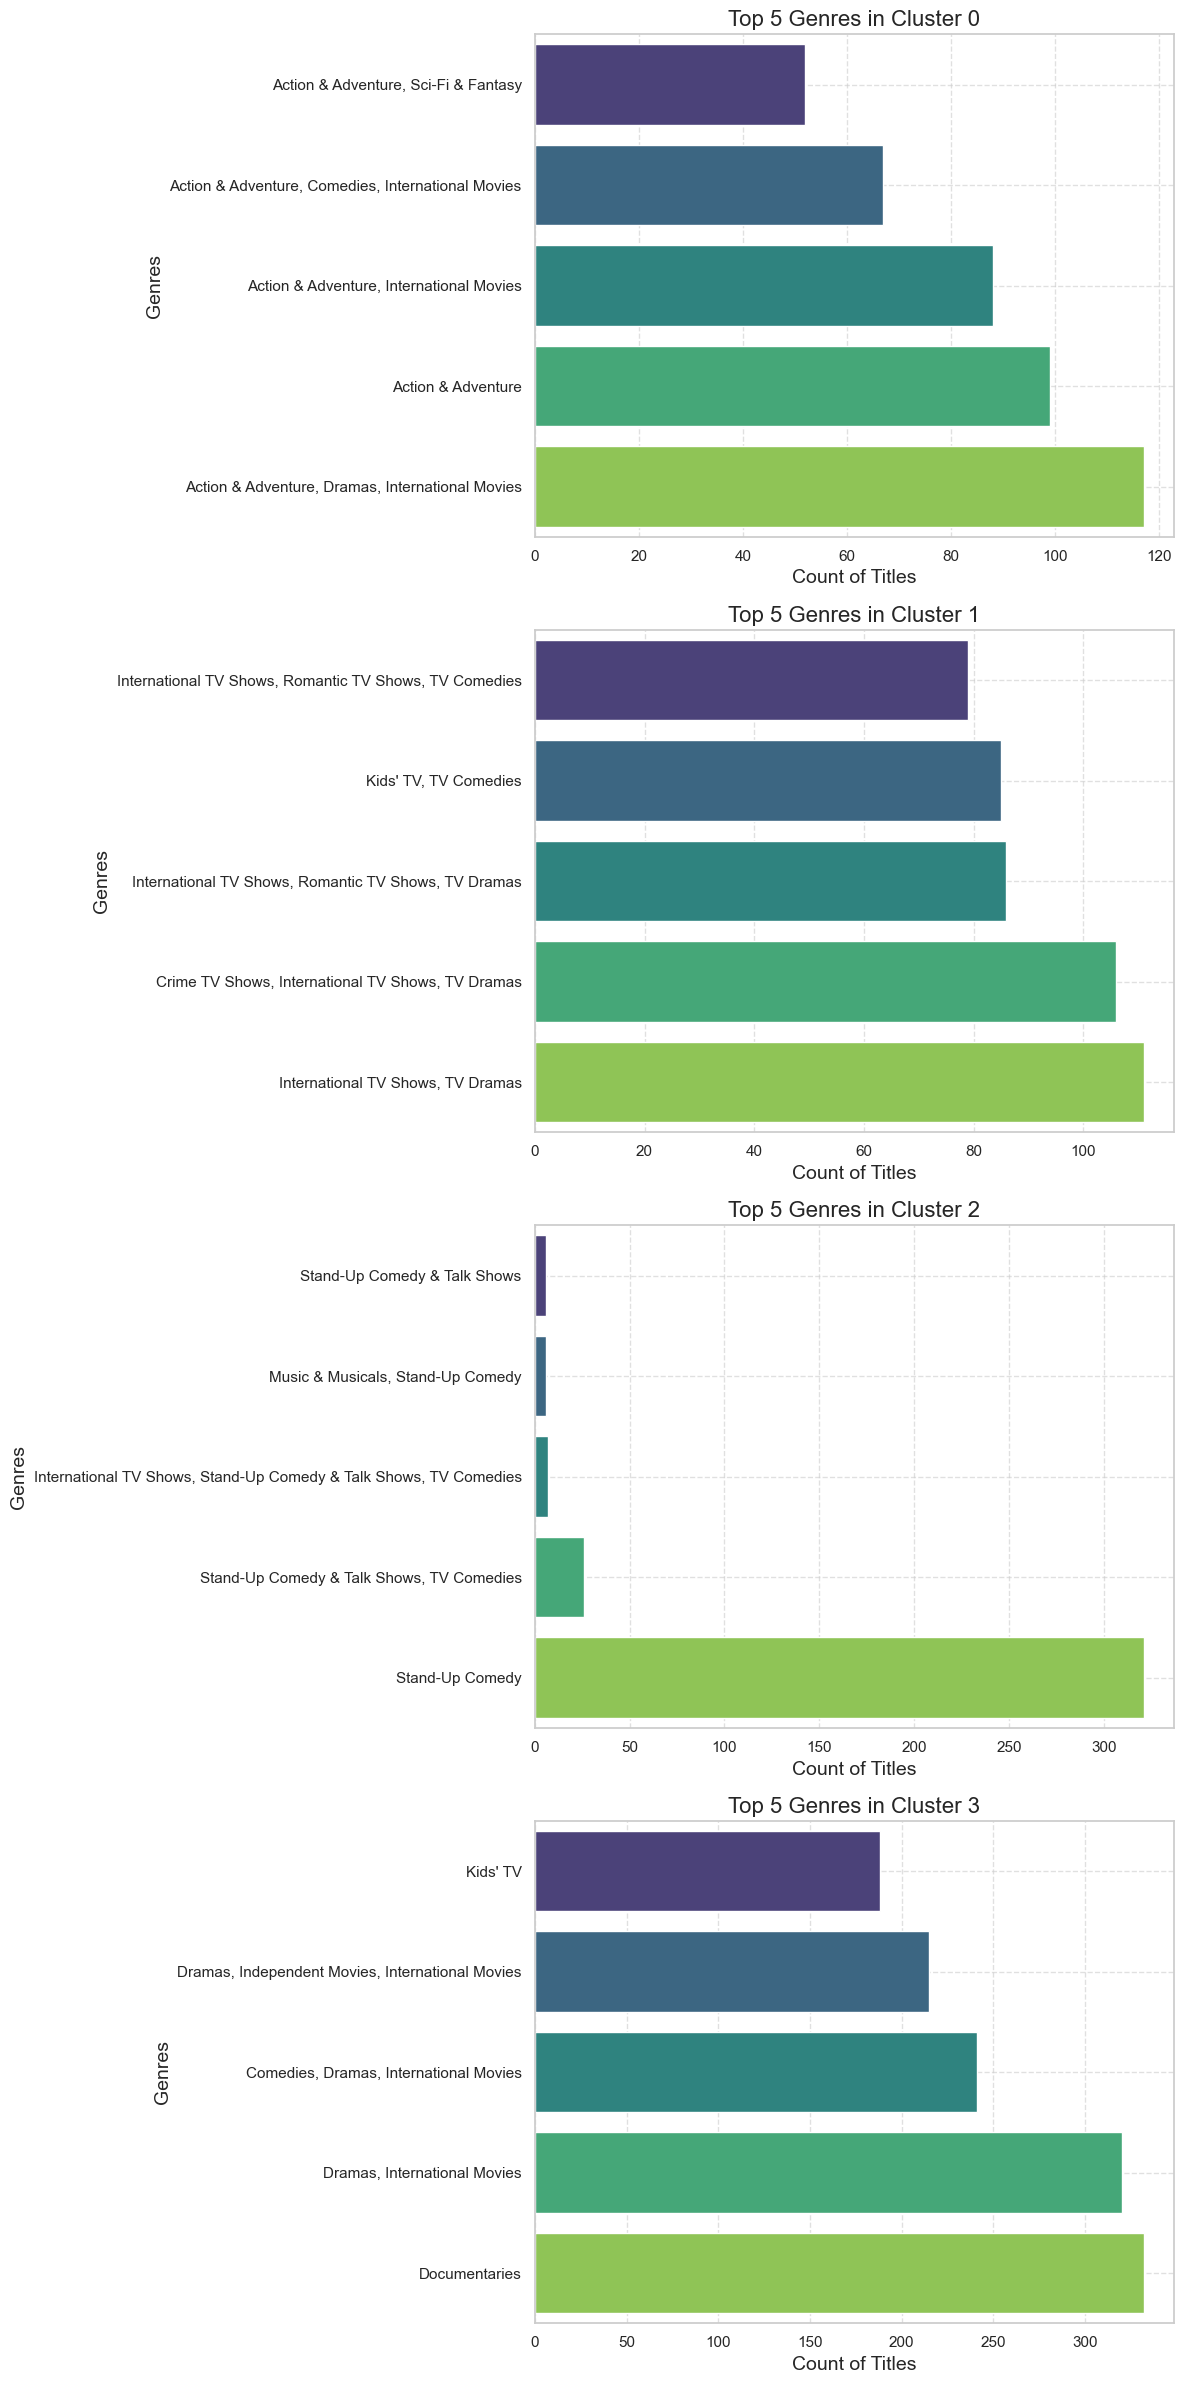

In [18]:
# Set the style for the plot
sns.set(style="whitegrid")

# Initialize the figure with a larger size and adjust subplots layout
fig, axes = plt.subplots(num_clusters, 1, figsize=(12, 6 * num_clusters))

# Loop through each cluster and plot the top genres
for i in range(num_clusters):
    cluster_data = netflix_data[netflix_data['cluster'] == i]
    top_genres = cluster_data['listed_in'].value_counts().head(5)

    # Sort the top genres to make the bars more ordered
    top_genres = top_genres.sort_values(ascending=True)
    
    # Plot the data for the current cluster
    sns.barplot(x=top_genres.values, y=top_genres.index, ax=axes[i], palette="viridis")
    
    # Set titles and labels with more descriptive names
    axes[i].set_title(f"Top 5 Genres in Cluster {i}", fontsize=16)
    axes[i].set_xlabel("Count of Titles", fontsize=14)
    axes[i].set_ylabel("Genres", fontsize=14)
    
    # Add a grid for better readability
    axes[i].grid(True, linestyle="--", alpha=0.6)

# Adjust the layout so that everything fits and looks clean
plt.tight_layout()
plt.show()

**Cluster 0:** 
 - The genres in this cluster suggest a high prevalence of action-oriented content like *Action & Adventure and International Movies*. The variety of genres in this cluster indicates a diverse set of movies or shows, catering to different types of audiences within the action and adventure theme.

**Cluster 1:**
-   This cluster seems to feature a strong focus on *International TV Shows and TV Dramas, with subgenres of crime, romance, and drama*. This suggests that Cluster 1 might be more oriented towards international or drama-heavy TV shows.

**Cluster 2:**
-  The dominance of *Stand-Up Comedy* in this cluster suggests that it mainly contains comedy-focused content. This cluster may represent a collection of stand-up comedy shows and talk shows, with fewer mixed genres. 

**Cluster 3:**
-   The genres in this cluster suggest a heavy presence of *Documentaries and Dramas,* particularly those that are international. This cluster might represent content that’s more serious or factual, such as documentaries and independent films.


By plotting the top genres for each cluster, you can gain insights into what each cluster represents. For instance, clusters with a mix of genres may indicate a broad audience, while clusters focused on specific genres (like Stand-Up Comedy or Documentaries) may indicate more niche audiences. The plots will visually highlight the most common genres in each cluster, which can help with understanding the segmentation of content in the dataset.

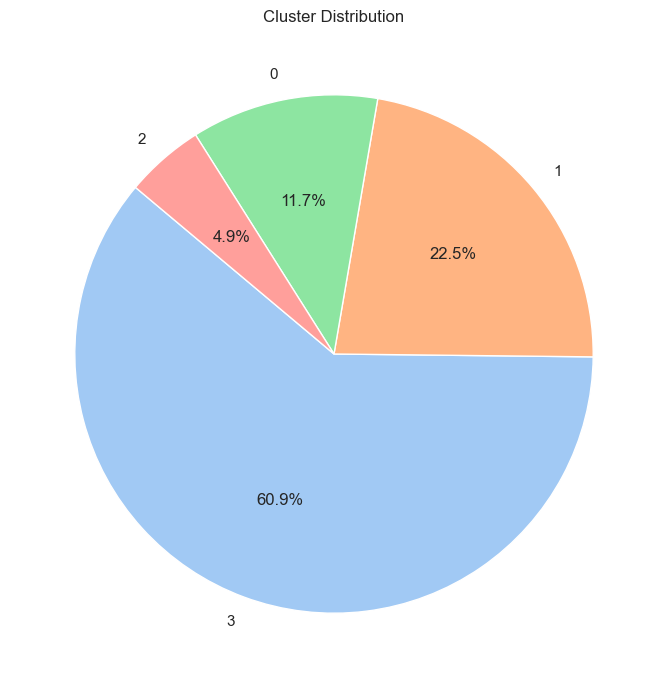

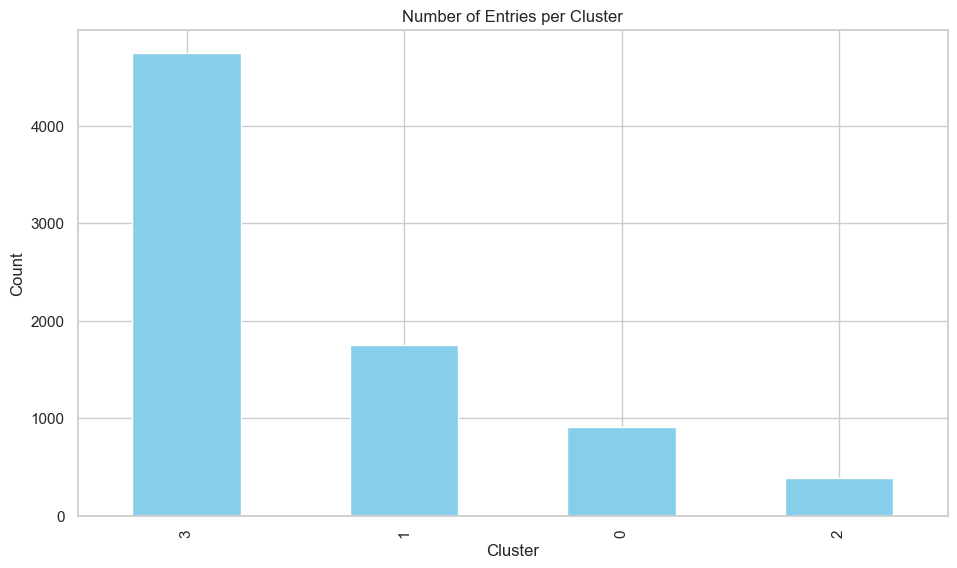

In [20]:
# Cluster size as a pie chart
cluster_counts = netflix_data['cluster'].value_counts()

plt.figure(figsize=(8, 8))
cluster_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel', len(cluster_counts)))
plt.title('Cluster Distribution')
plt.ylabel('')
plt.show()

# Cluster size as a bar chart
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Entries per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()


In [21]:
# Clean and standardize 'duration'
def clean_duration(value):
    if 'min' in value:
        return int(value.split(' ')[0])  # Extract numeric part for movies
    elif 'Season' in value:
        return None  # Leave out TV shows if focusing on minutes
    return None  

# Apply cleaning function
netflix_data['cleaned_duration'] = netflix_data['duration'].apply(lambda x: clean_duration(x) if isinstance(x, str) else None)

# Analysis: Calculate average and median duration only for movies
for i in range(num_clusters):
    cluster_data = netflix_data[(netflix_data['cluster'] == i) & (netflix_data['cleaned_duration'].notna())]  # Filter movies only
    avg_duration = cluster_data['cleaned_duration'].mean()
    median_duration = cluster_data['cleaned_duration'].median()
    print(f"Cluster {i}: Average Duration = {avg_duration:.1f} minutes, Median Duration = {median_duration} minutes")


Cluster 0: Average Duration = 111.5 minutes, Median Duration = 106.0 minutes
Cluster 1: Average Duration = nan minutes, Median Duration = nan minutes
Cluster 2: Average Duration = 67.2 minutes, Median Duration = 65.0 minutes
Cluster 3: Average Duration = 99.4 minutes, Median Duration = 98.0 minutes


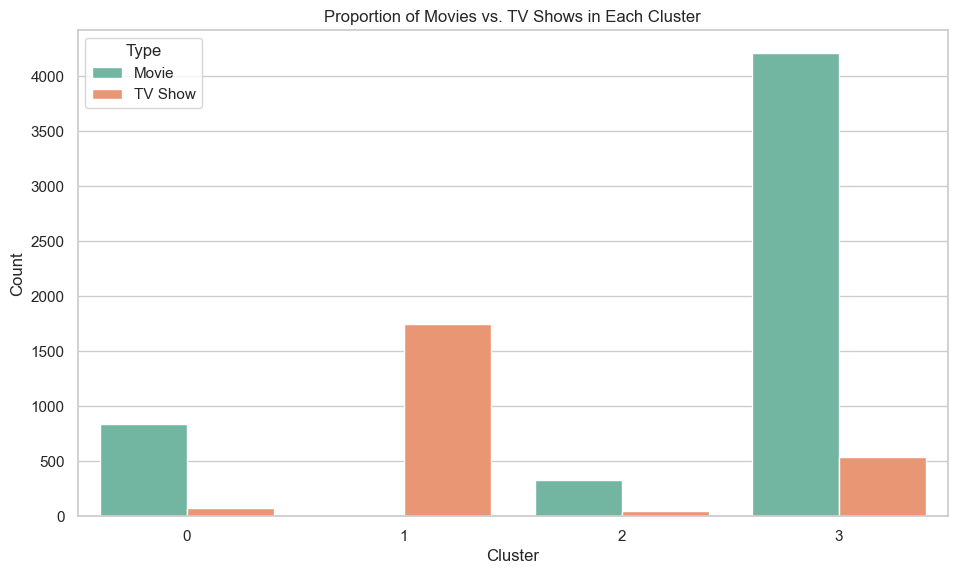

In [22]:

plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', hue='type', data=netflix_data, palette='Set2')
plt.title('Proportion of Movies vs. TV Shows in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Type')
plt.show()


In [23]:
# Split genres and count each genre's occurrence in each cluster
for i in range(num_clusters):
    cluster_data = netflix_data[netflix_data['cluster'] == i]
    genres = cluster_data['listed_in'].str.split(',').explode().str.strip()
    genre_counts = Counter(genres)
    top_genres = genre_counts.most_common(5)
    
    print(f"\nCluster {i} Top Genres:")
    for genre, count in top_genres:
        print(f"{genre}: {count}")


Cluster 0 Top Genres:
Action & Adventure: 721
International Movies: 388
Dramas: 235
Sci-Fi & Fantasy: 218
Comedies: 184

Cluster 1 Top Genres:
International TV Shows: 1180
TV Dramas: 646
Crime TV Shows: 426
TV Comedies: 413
Romantic TV Shows: 333

Cluster 2 Top Genres:
Stand-Up Comedy: 329
Stand-Up Comedy & Talk Shows: 49
TV Comedies: 35
International TV Shows: 13
Music & Musicals: 6

Cluster 3 Top Genres:
International Movies: 2048
Dramas: 1870
Comedies: 1285
Documentaries: 774
Independent Movies: 626


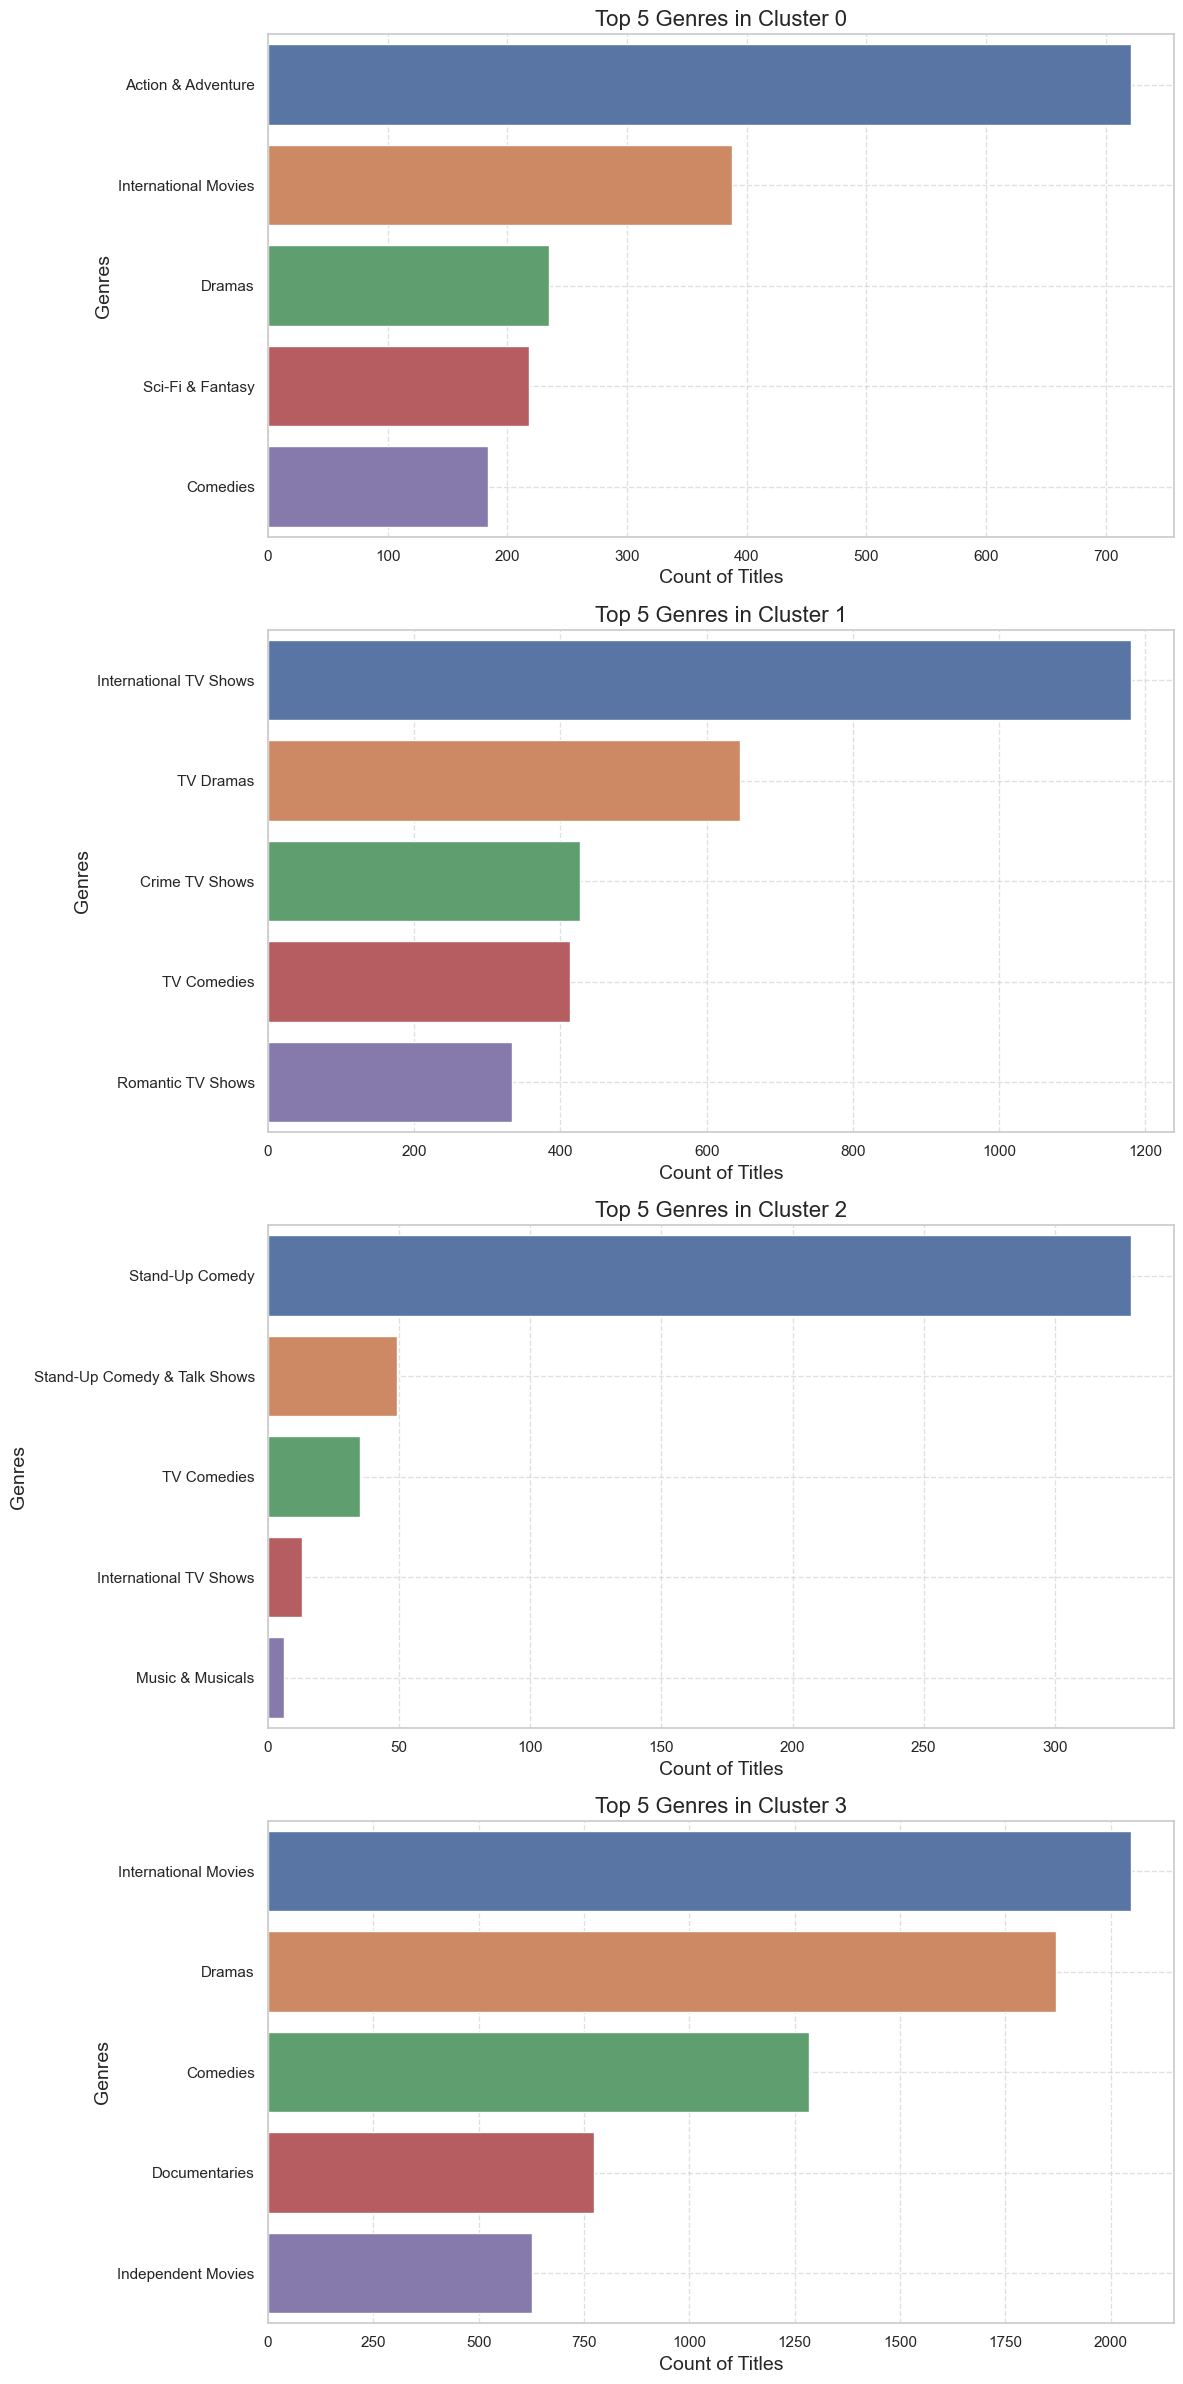

In [25]:
# Set the style for the plot
sns.set(style="whitegrid")

# Initialize the figure with a larger size and adjust subplots layout
fig, axes = plt.subplots(num_clusters, 1, figsize=(12, 6 * num_clusters))

# Loop through each cluster and plot the top genres
for i in range(num_clusters):
    cluster_data = netflix_data[netflix_data['cluster'] == i]
    genres = cluster_data['listed_in'].str.split(',').explode().str.strip()
    genre_counts = Counter(genres)
    top_genres = genre_counts.most_common(5)
    
    # Extract genre names and counts for plotting
    genre_names = [genre for genre, _ in top_genres]
    genre_counts = [count for _, count in top_genres]

    # Plot the data for the current cluster
    sns.barplot(x=genre_counts, y=genre_names, ax=axes[i], hue=genre_names)

    # Set titles and labels with more descriptive names
    axes[i].set_title(f"Top 5 Genres in Cluster {i}", fontsize=16)
    axes[i].set_xlabel("Count of Titles", fontsize=14)
    axes[i].set_ylabel("Genres", fontsize=14)
    
    # Add a grid for better readability
    axes[i].grid(True, linestyle="--", alpha=0.6)

# Adjust the layout so that everything fits and looks clean
plt.tight_layout()
plt.show()


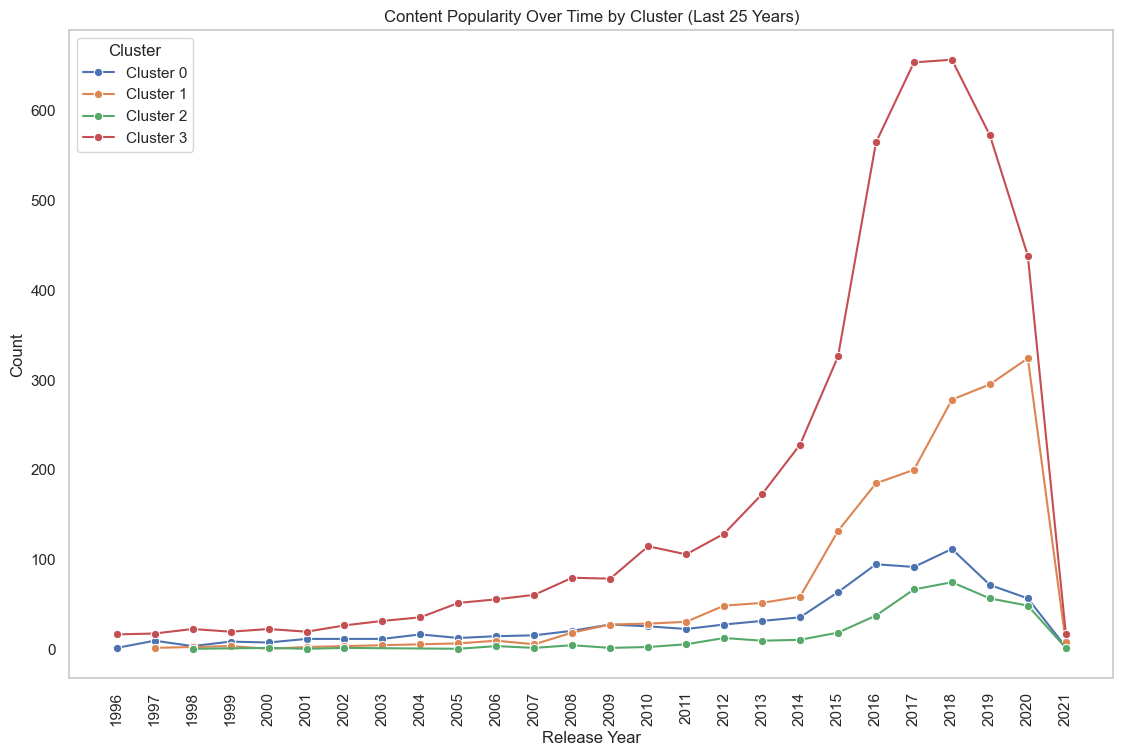

In [30]:
# Define the last 25 years
current_year = netflix_data['release_year'].max()
last_25_years = netflix_data[netflix_data['release_year'] >= (current_year - 25)]

plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    # Filter the cluster data for the last 25 years
    cluster_data = last_25_years[last_25_years['cluster'] == i]
    
    # Group by release year and count the number of entries
    yearly_data = cluster_data.groupby('release_year').size()
    
    # Plot the line for the current cluster
    sns.lineplot(data=yearly_data, label=f'Cluster {i}', marker='o')

plt.title('Content Popularity Over Time by Cluster (Last 25 Years)')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.legend(title='Cluster')
plt.xticks(yearly_data.index, rotation=90) 
plt.grid(False) 
plt.show()

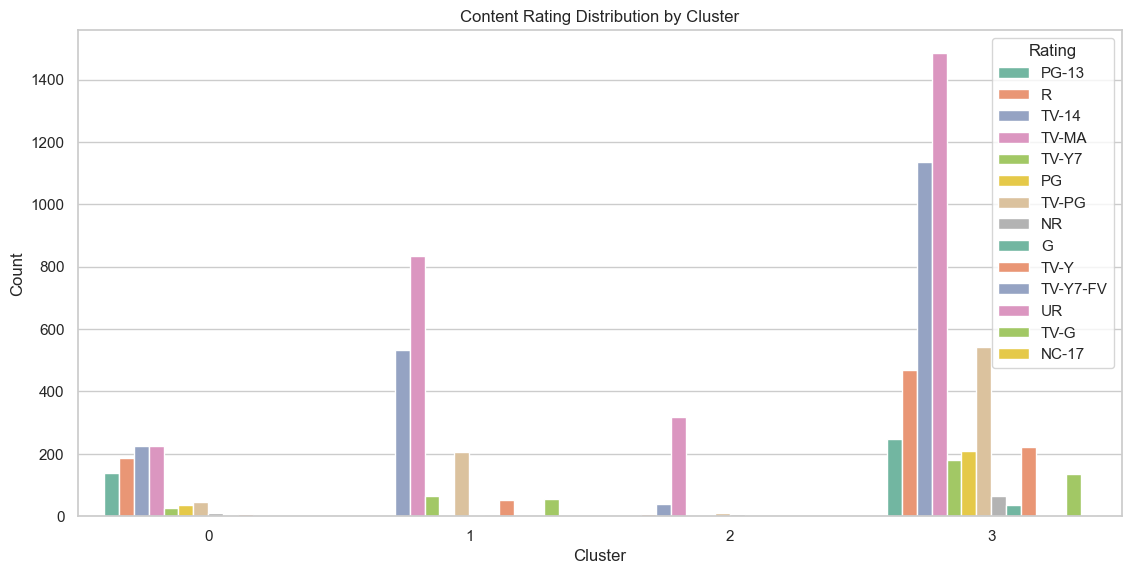

In [27]:
plt.figure(figsize=(12, 6))
sns.countplot(data=netflix_data, x='cluster', hue='rating', palette='Set2')
plt.title('Content Rating Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Rating')
plt.show()

<Figure size 1400x800 with 0 Axes>

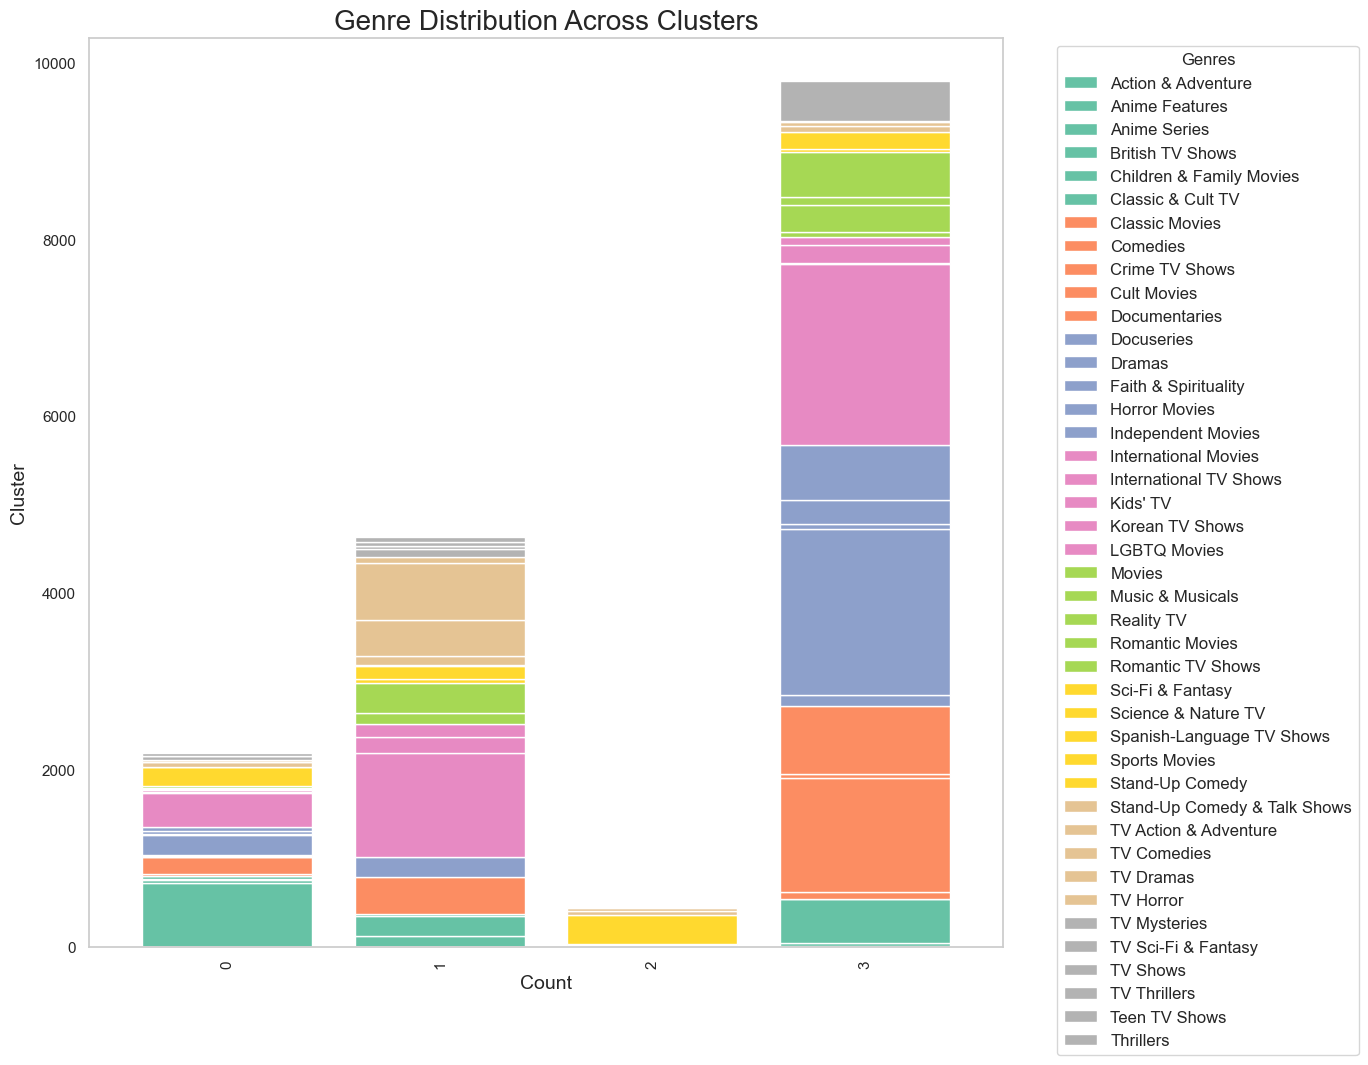

In [41]:
# Plotting genre distribution across clusters using a horizontal bar plot
plt.figure(figsize=(14, 8))
genre_cluster_counts.plot(kind='bar', stacked=True, colormap='Set2', figsize=(14, 11), width=0.8)

# Adding title and labels
plt.title('Genre Distribution Across Clusters', fontsize=20)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Cluster', fontsize=14)

# Customizing the legend and making sure it's readable
plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Removing gridlines
plt.grid(False)

# Adjust layout to avoid cutting off labels
plt.tight_layout()
plt.show()

C:\Users\Parameswar\AppData\Local\Temp\ipykernel_13272\4257276695.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=grouped_genre_data, x='release_year', y='Count', hue='Genre',


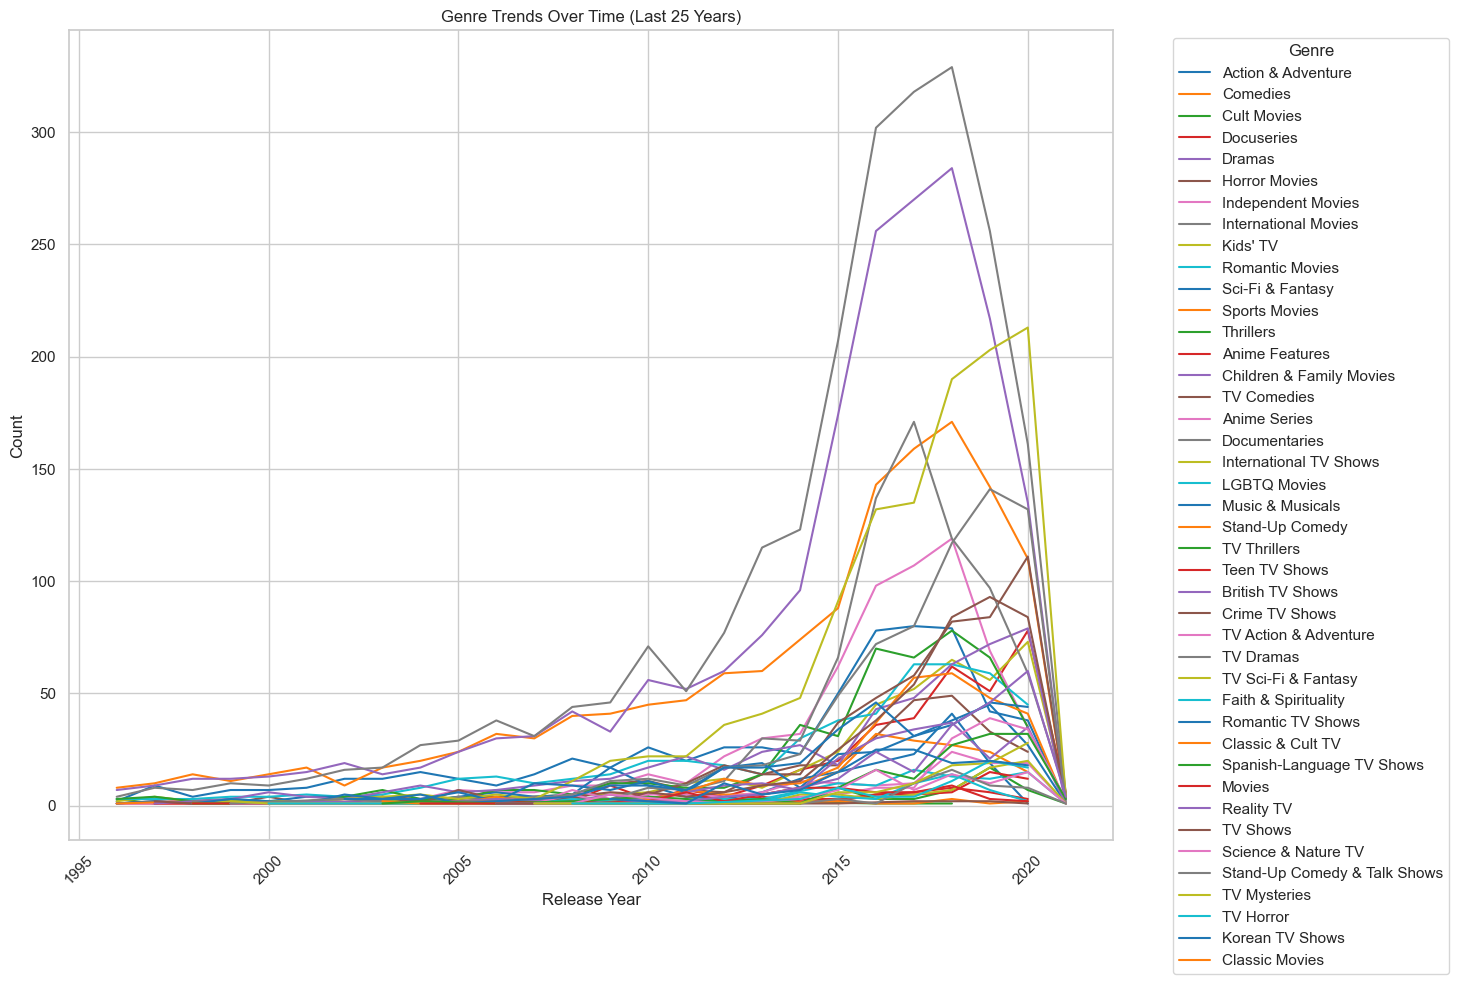

In [49]:
genre_counts = genre_counts.assign(release_year=netflix_data['release_year'])
melted_genre_data = genre_counts.melt(id_vars=['release_year'], var_name='Genre', value_name='Count')

# Filter for the last 25 years
melted_genre_data = melted_genre_data[melted_genre_data['release_year'] >= (current_year - 25)]

# Group by release_year and Genre to get the total counts
melted_genre_data = melted_genre_data[melted_genre_data['Count'] > 0]  # Remove zero counts
grouped_genre_data = melted_genre_data.groupby(['release_year', 'Genre'])['Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 10))
sns.lineplot(data=grouped_genre_data, x='release_year', y='Count', hue='Genre', 
             estimator='sum', ci=None, palette='tab10')
plt.title('Genre Trends Over Time (Last 25 Years)')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.show()


C:\Users\Parameswar\AppData\Local\Temp\ipykernel_13272\60095333.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=netflix_data, x='cluster', y='rating', palette='Set2')


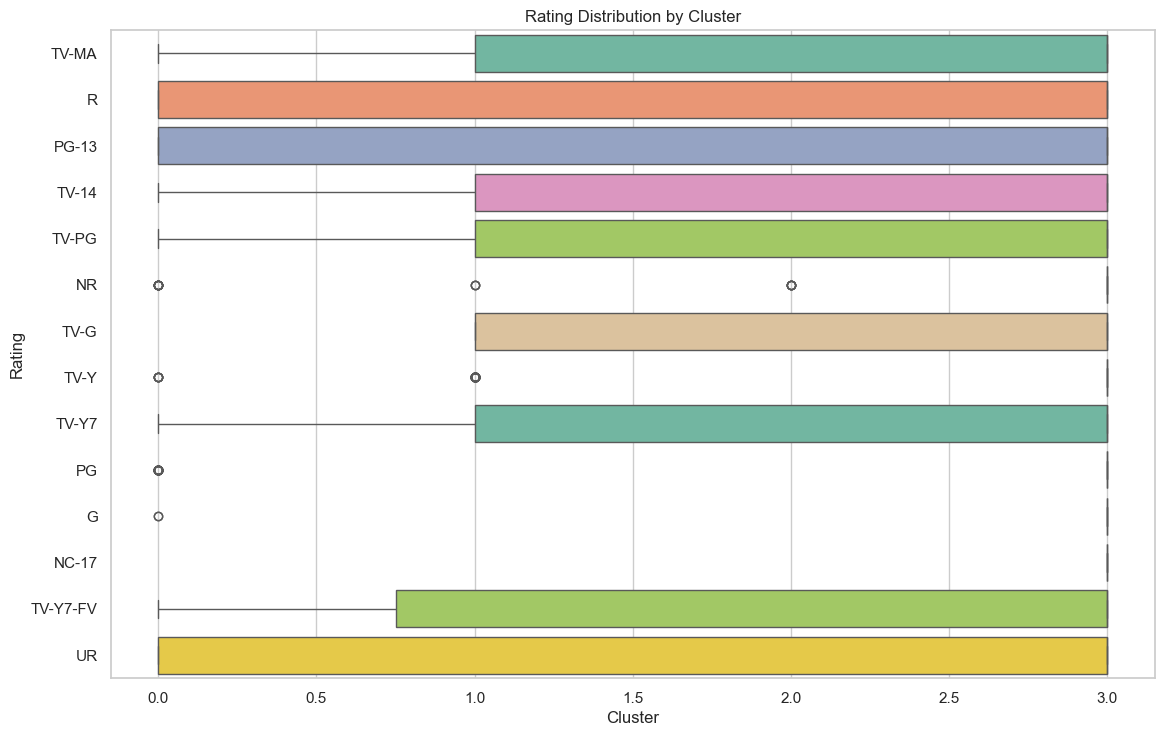

In [51]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=netflix_data, x='cluster', y='rating', palette='Set2')
plt.title('Rating Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Rating')
plt.show()


C:\Users\Parameswar\AppData\Local\Temp\ipykernel_13272\2448861892.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x='Count', y='Word', palette='Set2')


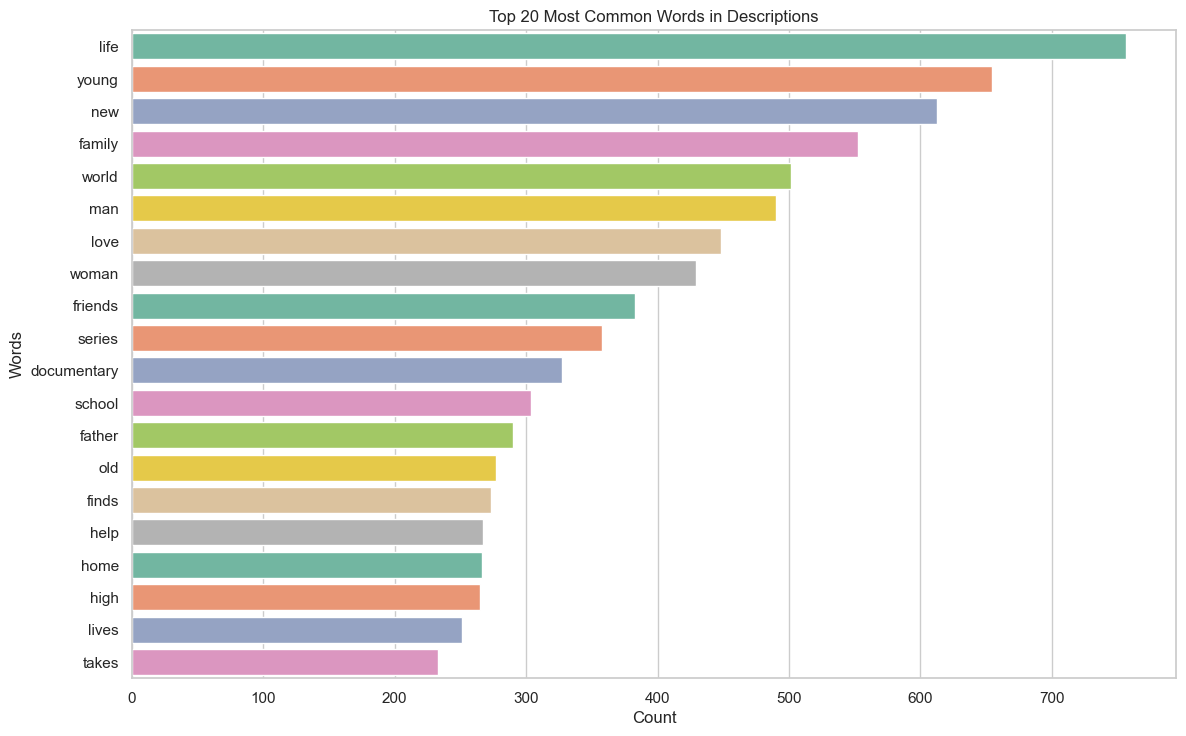

In [53]:
# Use CountVectorizer to find common words in descriptions
vectorizer = CountVectorizer(stop_words='english', max_features=100)
X = vectorizer.fit_transform(netflix_data['description'].fillna(''))

# Get the sum of word counts
word_counts = X.toarray().sum(axis=0)
word_freq = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Count': word_counts})
top_words = word_freq.sort_values(by='Count', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_words, x='Count', y='Word', palette='Set2')
plt.title('Top 20 Most Common Words in Descriptions')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()